In [1]:
import getpass
import os


# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")


# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

os.environ["OPENAI_API_KEY"] = "<ENTER KEY>"
os.environ["TAVILY_API_KEY"] = "<ENTER KEY>"

In [2]:
from langchain_openai import ChatOpenAI

gtp4omini = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

In [4]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [261]:
JSON_SAMPLE={
  "user": {
    "userId": "U123456789",
    "personalInfo": {
      "firstName": "Jane",
      "lastName": "Doe",
      "email": "jane.doe@example.com",
      "phone": "+1-555-123-4567",
      "creditScore": 720,
      "address": {
        "street": "123 Main St",
        "city": "Anytown",
        "state": "CA",
        "zipCode": "90210",
        "country": "USA"
      }
    }
  },
  "vehicle": {
    "vehicleId": "V987654321",
    "make": "Tesla",
    "model": "Model 3",
    "year": 2023,
    "trim": "Long Range",
    "msrp": 50000,
    "dealerDiscount": 2000,
    "options": [
      {
        "optionId": "O001",
        "optionName": "Autopilot",
        "optionPrice": 5000
      },
      {
        "optionId": "O002",
        "optionName": "Premium Interior",
        "optionPrice": 3000
      }
    ],
    "color": "Red Multi-Coat",
    "vin": "5YJ3E1EA7LF000000"
  },
  "tradeIn": {
    "hasTradeIn": True,
    "tradeInVehicle": {
      "make": "Honda",
      "model": "Civic",
      "year": 2015,
      "mileage": 60000,
      "estimatedValue": 10000,
      "outstandingLoan": 5000
    }
  },
  "financing": {
    "downPayment": 5000,
    "loanTermMonths": 72,
    "interestRate": 2.99,
    "salesTaxRate": 7.25,
    "fees": {
      "documentationFee": 80,
      "registrationFee": 400,
      "otherFees": [
        {
          "feeName": "Tire Recycling Fee",
          "feeAmount": 5
        },
        {
          "feeName": "Electronic Filing Fee",
          "feeAmount": 30
        }
      ]
    },
    "rebates": [
      {
        "rebateName": "Electric Vehicle Rebate",
        "rebateAmount": 1500
      }
    ]
  },
  "insurance": {
    "provider": "Acme Insurance",
    "policyNumber": "INS123456789",
    "monthlyPremium": 150,
    "coverage": {
      "liability": "100/300/50",
      "collision": True,
      "comprehensive": True,
      "uninsuredMotorist": True,
      "personalInjuryProtection": False
    }
  },
  "calculatedResults": {
    "totalVehiclePrice": 53000,
    "totalDiscounts": 3500,
    "priceAfterDiscounts": 49500,
    "tradeInCredit": 5000,
    "taxableAmount": 44500,
    "salesTaxAmount": 3226.25,
    "totalFees": 515,
    "totalRebates": 1500,
    "amountFinanced": 45741.25,
    "estimatedMonthlyPayment": 682.15,
    "loanAmortizationSchedule": [
      {
        "month": 1,
        "principal": 500,
        "interest": 114,
        "balance": 45241.25
      }
    ]
  },
  "metadata": {
    "calculationDate": "2023-10-15T14:30:00Z",
    "currency": "USD",
    "locale": "en-US",
    "version": "1.0.0"
  }
}

questions = [
    # Vehicle and Initial Details
    "What car are you looking at? Please include the year and trim if possible.",
    
    # Payment and Trade-in Details
    "Will you be making a down payment or trading in a vehicle?",

    # Finance or Lease Preference
    "Do you want to finance or lease the car? If leasing, how many miles per year?",

    # Term and Rate Preferences
    "If financing, how long would you like the loan term to be? Any preferred APR?",

    # Additional Information
    "Is there any other detail I should know, like incentives or your ZIP code for accurate pricing?"
]

essential_questions= {
  "questions": [
    {
      "question": "What car are you looking at? Please include the year and trim if possible.",
      "answer": ""
    },
    {
      "question": "Will you be making a down payment or trading in a vehicle?",
      "answer": ""
    },
    {
      "question": "Do you want to finance or lease the car? If leasing, how many miles per year?",
      "answer": ""
    },
    {
      "question": "If financing, how long would you like the loan term to be? Any preferred APR?",
      "answer": ""
    },
    {
      "question": "Is there any other detail I should know, like incentives or your ZIP code for accurate pricing?",
      "answer": ""
    }
  ]
}

In [262]:
import json
import re

# tools

def validate_json(state) -> dict:
    json_string = state["user_info_json"]
    # Remove potential markdown code block indicators
    json_string_cleaned = re.sub(r"```json|```", "", json_string.strip())
    
    try:
        # Attempt to parse the cleaned JSON string
        parsed_json = json.loads(json_string_cleaned)
        return {"json_validated": True, "feedback": "", "user_info_json": parsed_json}
    except json.JSONDecodeError as e:
        # Return the exception message if JSON is invalid
        return {"json_validated": False, "feedback": str(e)}

def get_unanswered_question(state):
    
    # Loop through each question in the JSON
    for question_data in state['essential_questions']['questions']:
        # If the answer field is empty, return the question and False
        if question_data['answer']=="":
            return {"next_question":question_data['question'], "all_question_answered":False}
    
    # If all questions are answered, return the input JSON and True
    return {"all_question_answered":True}

# def ask_user_input(state):
#     user_response = input(f"{state['next_question']}\nUser: ")
#     return {"messages":[user_response]}

def human_feedback(state):
    print("---human_feedback---")
    user_input = input("User: ")
    # Loop through each question in the JSON
    for question_data in state['essential_questions']['questions']:
        # If the answer field is empty, return the question and False
        if question_data['answer']=="":
            question_data['answer']=user_input
            return {"messages":[user_input]}

def are_questions_remaining(state):
    pass

def router(state):
    if state["all_question_answered"]:
        return "no"
    else:
        return "yes"

In [263]:
from langchain_core.prompts import ChatPromptTemplate

# prompt templates and prompts
extract_user_info_template = """
You are an AI tasked with extracting user information from a given message. 
Your goal is to accurately fill in the information required in the provided API JSON template using the information available in the filled-out questions JSON and the user's current message. 
Do not make assumptions or fill in details that are not explicitly mentioned in either the questions JSON or the message.
Leave fields empty or null if the information is not present.
Provide your response in JSON format.

Here is the API JSON structure you need to fill:
```json
{json}
```

Here is the filled-out essential questions JSON containing user-provided information:
```json
{essential_questions}
```

Please accurately fill the API JSON using any relevant details from both the filled-out questions JSON and the user message, and return the updated API JSON. 
If certain details are missing or unclear from the message or filled-out questions JSON, leave those fields as null or empty. 
Do not invent information or guess.

Response:
"""
extract_user_info_prompt = ChatPromptTemplate.from_template(extract_user_info_template)
extract_user_info_chain = extract_user_info_prompt | gtp4omini

determine_conversation_intent_template = """
You are an AI tasked with identifying the intent behind the user's message. 
Based on the user's response, you need to determine if the user wants to end the current conversation or is interrupting the conversation flow. 
If the user's message indicates that they want to end the conversation, respond with the JSON "end_chat". 
If their message is interrupting the flow or unrelated, also respond with "end_chat". 
Otherwise, respond with "continue".

Consider the following:
- If the user's response is answering the question then the conversation should "continue".
- If the message is unrelated to the current conversation or interrupts the flow, also consider it as "end_chat"
- If the user is still engaging with the topic or asking for further help, the intent should be "continue"

You will only respond either "end_chat" or "continue"

Current Question: {question}
User message: {user_message}

Response:
"""
determine_conversation_intent_prompt = ChatPromptTemplate.from_template(determine_conversation_intent_template)
determine_conversation_intent_chain = determine_conversation_intent_prompt | gtp4omini

follow_up_question_creator_template = """
"""
follow_up_question_creator_prompt = ChatPromptTemplate.from_template(follow_up_question_creator_template)

In [264]:
# functions
def extract_possible_data(state):
    response = extract_user_info_chain.invoke({"json":state["json"], "essential_questions":state["essential_questions"]})

    return response.content

def determine_conversation_intent(state):
    if not state['all_question_answered']:
        response = determine_conversation_intent_chain.invoke({"question":state["next_question"], "user_message":state["messages"][-1]})
        print(f"determine_conversation_intent: {response.content}")
        return response.content
    else:
        return "end_chat"

In [265]:
# define graph state
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    json: dict
    essential_questions: dict
    next_question: str
    all_question_answered: bool
    json_validated: bool
    feedback: str

graph_builder = StateGraph(State)

### Define Nodes and Edge Logic

In [266]:
# nodes
graph_builder.add_node("are_there_more_questions", are_questions_remaining)
graph_builder.add_node("Ask_Question", get_unanswered_question)
graph_builder.add_node("user_input", human_feedback)
graph_builder.add_node("Extract_Info", extract_possible_data)
#graph_builder.add_node("continue_conversation_check", determine_conversation_intent)

In [267]:
# edge logic
graph_builder.add_edge(START, "are_there_more_questions")
graph_builder.add_conditional_edges(
    "are_there_more_questions",
    router,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    {"no": "Extract_Info", "yes": "Ask_Question"},
)
graph_builder.add_edge("Ask_Question", "user_input")
graph_builder.add_conditional_edges(
    "user_input",
    determine_conversation_intent,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    {"continue": "are_there_more_questions", "end_chat": "Extract_Info"},
)
graph_builder.add_edge("Extract_Info", END)

In [268]:
graph = graph_builder.compile()
graph

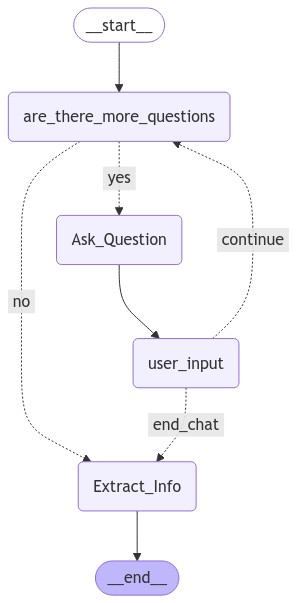

In [269]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
# try:
#     display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

In [270]:
def stream_graph_updates(all_question_answered: bool, json: dict, essential_questions: dict):
    for event in graph.stream({"all_question_answered": all_question_answered, "json":json, "essential_questions":essential_questions}):
        for value in event.values():
            print("Assistant:", value)

In [271]:
stream_graph_updates(all_question_answered=False, json=json, essential_questions=essential_questions)

Assistant: None
Assistant: {'next_question': 'What car are you looking at? Please include the year and trim if possible.', 'all_question_answered': False}
---human_feedback---


User:  I want a mustang


determine_conversation_intent: continue
Assistant: {'messages': ['I want a mustang']}
Assistant: None
Assistant: {'next_question': 'Will you be making a down payment or trading in a vehicle?', 'all_question_answered': False}
---human_feedback---


User:  down payment


determine_conversation_intent: continue
Assistant: {'messages': ['down payment']}
Assistant: None
Assistant: {'next_question': 'Do you want to finance or lease the car? If leasing, how many miles per year?', 'all_question_answered': False}
---human_feedback---


User:  finance


determine_conversation_intent: continue
Assistant: {'messages': ['finance']}
Assistant: None
Assistant: {'next_question': 'If financing, how long would you like the loan term to be? Any preferred APR?', 'all_question_answered': False}
---human_feedback---


User:  not sure, but I can afford $500 per month


determine_conversation_intent: continue
Assistant: {'messages': ['not sure, but I can afford $500 per month']}
Assistant: None
Assistant: {'next_question': 'Is there any other detail I should know, like incentives or your ZIP code for accurate pricing?', 'all_question_answered': False}
---human_feedback---


User:  my zip code is 48126


determine_conversation_intent: continue
Assistant: {'messages': ['my zip code is 48126']}
Assistant: None
Assistant: {'all_question_answered': True}
---human_feedback---


KeyboardInterrupt: Interrupted by user